In [1]:
%load_ext autoreload
%autoreload 2

In [113]:
from pathlib import Path

import numpy as np
from scipy import io
import matplotlib.pyplot as plt

import pykilosort as ks
from pykilosort import datashift
from pykilosort.learn import learnAndSolve8b, mexSVDsmall2, extractTemplatesfromSnippets, getMeUtU
from pykilosort.utils import Bunch, Context


In [3]:
matlab_input = io.loadmat("/home/alexmorley/git_repos/kilosort-testing/eMouse/learnAndSolve8b_input.mat", struct_as_record=False)

rez = matlab_input["rez"]

In [4]:
# bit of data muching to get things in the same format with new params/probe stype

rez_dict = {f: getattr(rez[0][0], f) for f in rez[0][0]._fieldnames}
rez_dict["ops"] = {f: getattr(rez_dict["ops"][0][0], f) for f in rez_dict["ops"][0][0]._fieldnames}
xc = np.array(rez_dict["xc"].flat)
yc = np.array(rez_dict["yc"].flat)
iorig = rez_dict["iorig"].flatten() - 1

Nchan = rez_dict["ops"]["Nchan"]
Nbatch = rez_dict["ops"]["Nbatch"][0][0]

probe = ks.params.Probe(xc=xc, yc=yc, Nchan=Nchan, NchanTOT=Nchan,
                chanMap=np.array([]), kcoords=np.array([]))

rez_dict["ops"]["Th"] = list(rez_dict["ops"]["Th"][0])
rez_dict["ops"]["momentum"] = list(rez_dict["ops"]["momentum"][0])

params = ks.params.KilosortParams(**rez_dict["ops"], probe=probe);

proc_path = rez_dict['ops']['fproc'][0]
proc = np.memmap(proc_path, dtype=np.int16, mode="r", order="F")

In [5]:
ctx = Context(Path('/tmp/.kilosort)'))
ir = ctx.intermediate = Bunch()

ctx.params = params
ctx.probe = probe

ir.Nbatch = Nbatch
ir.proc = proc

ir.iorig = iorig

In [6]:
import cupy as cp

mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()

results = learnAndSolve8b(ctx)

Extracting templates: 100%|█████████████████████████████████| 3/3 [00:00<00:00,  6.92it/s]


> /home/alexmorley/git_repos/pykilosort/pykilosort/learn.py(933)learnAndSolve8b()
-> for ibatch in tqdm(range(niter), desc="Optimizing templates"):
(Pdb) C2C
array([[  0.      ,  32.      ,  25.612497, ..., 600.8527  , 620.2064  ,
        620.2064  ],
       [ 32.      ,   0.      ,  51.999996, ..., 600.      , 621.8553  ,
        620.2064  ],
       [ 25.612497,  51.999996,   0.      , ..., 581.9828  , 600.      ,
        600.8527  ],
       ...,
       [600.8527  , 600.      , 581.9828  , ...,   0.      ,  51.999996,
         25.612497],
       [620.2064  , 621.8553  , 600.      , ...,  51.999996,   0.      ,
         32.      ],
       [620.2064  , 620.2064  , 600.8527  , ...,  25.612497,  32.      ,
          0.      ]], dtype=float32)
(Pdb) q


BdbQuit: 

Extracting templates: 100%|█████████████████████████████████| 3/3 [00:00<00:00, 15.22it/s]


Text(0.5, 1.02, 'extractTemplatesfromSnippets')

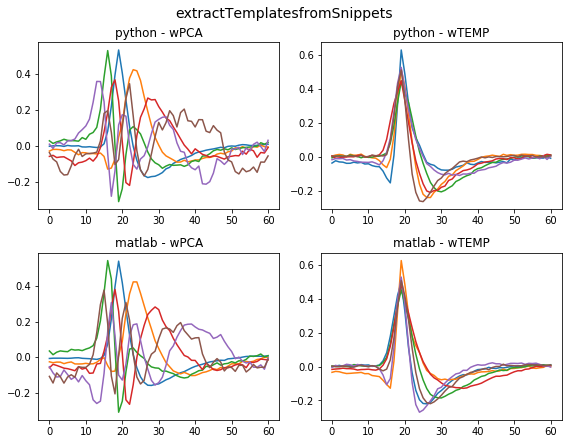

In [66]:
################################
# extractTemplatesfromSnippets #
################################

matlab_output = io.loadmat("/home/alexmorley/git_repos/kilosort-testing/eMouse/extractTemplatesfromSnippets_output.mat", struct_as_record=False)

NrankPC = 6
wTEMP, wPCA = extractTemplatesfromSnippets(
    proc=ctx.intermediate.proc, probe=probe, params=params, Nbatch=Nbatch, nPCs=NrankPC
)

expected_wPCA = matlab_output["wPCA_"]
expected_wPCA[:,np.max(expected_wPCA,axis=0) < np.abs(np.min(expected_wPCA,axis=0))] *= -1

expected_wTEMP = matlab_output["wTEMP_"]
expected_wTEMP[:,np.max(expected_wTEMP,axis=0) < np.abs(np.min(expected_wTEMP,axis=0))] *= -1

f, axs = plt.subplots(2,2, figsize=(8,6))
axs[0,0].set_title("python - wPCA")
wPCA[:,np.max(wPCA,axis=0) < np.abs(np.min(wPCA,axis=0))] *= -1
axs[0,0].plot(cp.asnumpy(wPCA))

axs[1,0].set_title("matlab - wPCA")
axs[1,0].plot(expected_wPCA)

axs[0,1].set_title("python - wTEMP")
wTEMP[:,np.max(wTEMP,axis=0) < np.abs(np.min(wTEMP,axis=0))] *= -1
axs[0,1].plot(cp.asnumpy(wTEMP))

axs[1,1].set_title("matlab - wTEMP")
axs[1,1].plot(expected_wTEMP)


f.tight_layout()
f.suptitle("extractTemplatesfromSnippets", y=1.02, size=14)


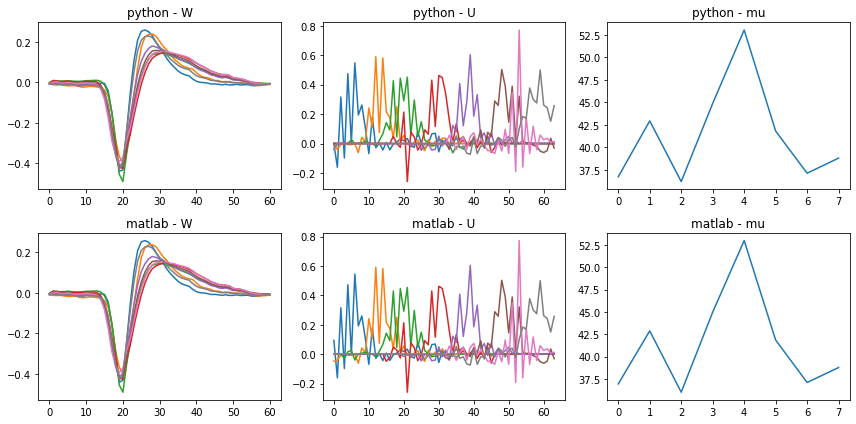

In [112]:
###########################################################
# W, U, mu = mexSVDsmall2(Params, dWU, W, iC, iW, Ka, Kb) #
###########################################################

matlab_input = io.loadmat("/home/alexmorley/git_repos/kilosort-testing/eMouse/mexSVDsmall_input.mat", struct_as_record=False)
matlab_output = io.loadmat("/home/alexmorley/git_repos/kilosort-testing/eMouse/mexSVDsmall_output.mat", struct_as_record=False)

Params = matlab_input["Params"][0]
dWU = matlab_input["dWU_"]
W = matlab_input["W_"]
iC = matlab_input["iC_"]
iW = matlab_input["iW_"]
Ka = matlab_input["Ka_"]
Kb = matlab_input["Kb_"]

expected_W = matlab_output["W_"]
expected_U = matlab_output["U_"]
expected_mu = matlab_output["mu_"]

W, U, mu = mexSVDsmall2(Params, dWU, W, iC, iW, Ka, Kb)

f, axs = plt.subplots(2,3, figsize=(12,6))
axs[0,0].set_title("python - W")
axs[0,0].plot(cp.asnumpy(W[:,:,0]))

axs[1,0].set_title("matlab - W")
axs[1,0].plot(expected_W[:,:,0])

axs[0,1].set_title("python - U")
axs[0,1].plot(cp.asnumpy(U[:,:,0]))

axs[1,1].set_title("matlab - U")
axs[1,1].plot(expected_U[:,:,0])

axs[0,2].set_title("python - mu")
axs[0,2].plot(cp.asnumpy(mu))

axs[1,2].set_title("matlab - mu")
axs[1,2].plot(expected_mu)

f.tight_layout()

In [119]:
iW - 1

array([[ 6],
       [14],
       [19],
       [31],
       [36],
       [48],
       [53],
       [56]], dtype=int32)

In [132]:
mask

array([[6.2766957e-01, 6.9121593e-01, 6.1721021e-01, ..., 6.1721021e-01,
        6.9121593e-01, 6.2766957e-01],
       [4.3596828e-01, 4.8010641e-01, 4.2870337e-01, ..., 4.2870337e-01,
        4.8010641e-01, 4.3596828e-01],
       [4.3596828e-01, 3.9133474e-01, 4.2870337e-01, ..., 4.2870337e-01,
        3.9133474e-01, 4.3596828e-01],
       ...,
       [4.3124926e-20, 4.7490963e-20, 8.4016702e-18, ..., 8.4016702e-18,
        4.7490963e-20, 4.3124926e-20],
       [1.0501242e-22, 1.1564406e-22, 7.4902387e-20, ..., 7.4902387e-20,
        1.1564406e-22, 1.0501242e-22],
       [1.0501242e-22, 3.7067447e-23, 4.2406299e-20, ..., 4.2406299e-20,
        3.7067447e-23, 1.0501242e-22]], dtype=float32)

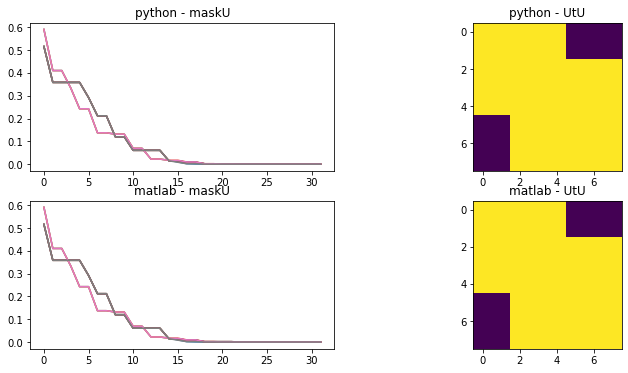

In [137]:
########################################################
# UtU, maskU = getMeUtU(iW, iC, mask, Nnearest, Nchan) #
########################################################

matlab_input = io.loadmat("/home/alexmorley/git_repos/kilosort-testing/eMouse/getMeUtU_input.mat", struct_as_record=False)
matlab_output = io.loadmat("/home/alexmorley/git_repos/kilosort-testing/eMouse/getMeUtU_output.mat", struct_as_record=False)

iW = matlab_input["iW_"] - 1
iC = matlab_input["iC_"] - 1
mask = matlab_input["mask_"]
Nnearest = matlab_input["Nnearest"][0][0]
Nchan = matlab_input["Nchan"][0][0]

expected_UtU = matlab_output["UtU_"]
expected_maskU = matlab_output["maskU_"]

UtU, maskU = getMeUtU(iW, iC, mask, Nnearest, Nchan)

f, axs = plt.subplots(2,2, figsize=(12,6))
axs[0,0].set_title("python - maskU")
axs[0,0].plot(maskU[:,:,0])

axs[1,0].set_title("matlab - maskU")
axs[1,0].plot(expected_maskU)

axs[0,1].set_title("python - UtU")
axs[0,1].imshow(cp.asnumpy(UtU))

axs[1,1].set_title("matlab - UtU")
axs[1,1].imshow(expected_UtU)


In [ ]:
 
f, axs = plt.subplots(2,3, figsize=(12,6))
axs[0,0].set_title("python - W")
axs[0,0].plot(cp.asnumpy(W[:,:,0]))

axs[1,0].set_title("matlab - W")
axs[1,0].plot(expected_W[:,:,0])

axs[0,1].set_title("python - U")
axs[0,1].plot(cp.asnumpy(U[:,:,0]))

axs[1,1].set_title("matlab - U")
axs[1,1].plot(expected_U[:,:,0])

axs[0,2].set_title("python - mu")
axs[0,2].plot(cp.asnumpy(mu))

axs[1,2].set_title("matlab - mu")
axs[1,2].plot(expected_mu)

f.tight_layout()

In [ ]:



W, U, mu = mexSVDsmall2(Params, dWU, W, iC, iW, Ka, Kb)

In [7]:
matlab_output = io.loadmat("/home/alexmorley/git_repos/kilosort-testing/eMouse/learnAndSolve8b_output.mat", struct_as_record=False)

In [8]:
rez = matlab_output['rez']
rez_dict = {f: getattr(rez[0][0], f) for f in rez[0][0]._fieldnames}
rez_dict["ops"] = {f: getattr(rez_dict["ops"][0][0], f) for f in rez_dict["ops"][0][0]._fieldnames}

expected_st3 = rez_dict['st3']

In [9]:
st3 = results['st3']


    python
    ---
    Total spikes: 32537
    Total units: 204
    

    matlab
    ---
    Total spikes: 47814
    Total units: 148
    


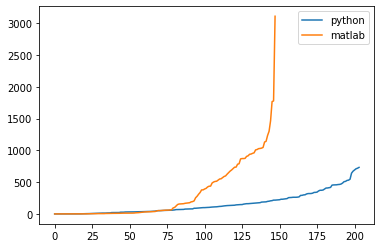

In [33]:
def proc(st3, title):
    res = st3[:,0]
    clu = st3[:,1]
    unit_ids = np.unique(clu)
    n_units = len(unit_ids)

    spike_times = [np.sort(res[clu==c]) for c in unit_ids]

    plt.plot(sorted([len(s) for s in spike_times]), label=title)
    
    print(f"""
    {title}
    ---
    Total spikes: {len(res)}
    Total units: {n_units}
    """)

proc(st3, "python")
proc(expected_st3, "matlab")

plt.legend()